In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd gdrive/MyDrive/Project V

/content/gdrive/MyDrive/Project V


In [4]:
!ls

bert_model_bbc	dataset  source


In [5]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
import datetime
import time, random
import matplotlib.pyplot as plt
from tabulate import tabulate
from functools import reduce

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertTokenizer,get_linear_schedule_with_warmup

import torch
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [7]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0


In [8]:
random_seed = 10

In [12]:
file_path = './dataset/stock_market_2022.csv'
dataframe = pd.read_csv(file_path)
columns = ['text', 'text_sentiment', 'likecount', 'replycount', 'user followers count', 'hashtags']
dataframe = dataframe.loc[:, columns]
dataframe.head(3)

,text,text_sentiment,likecount,replycount,user followers count,hashtags
0,When will the #NYSE #stockmarketcrash happen?,Neutral,1,0,10669,"['NYSE', 'stockmarketcrash']"
1,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,8,0,100,"['stockmarkets', 'stockmarketcrash', 'trading'..."
2,The stock market needs to crash hard to make i...,Negative,0,0,0,"['stockmarketcrash', 'economy', 'rich', 'Fed']"


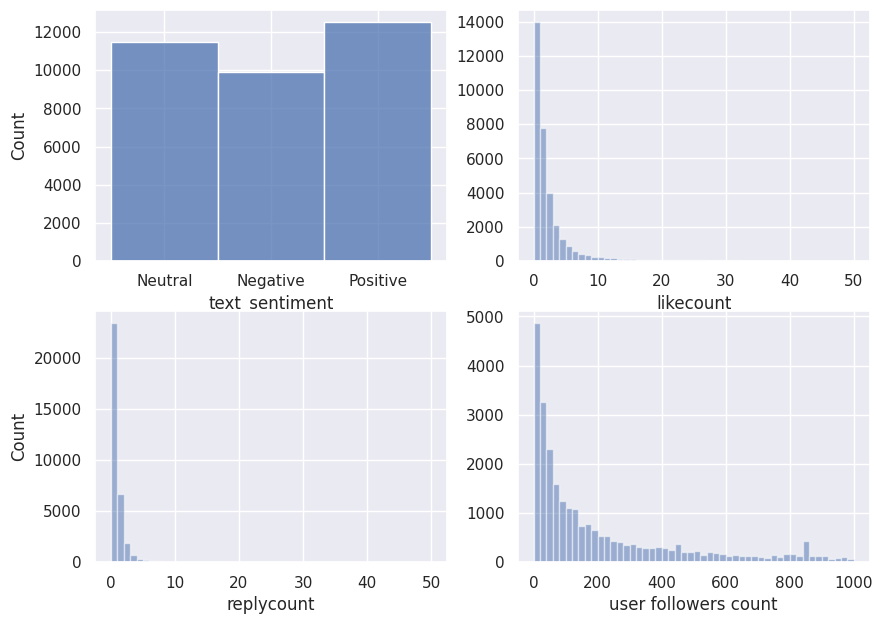

In [13]:
plt.figure(figsize=(10,15))
sns.set(style='darkgrid')
plt.subplot(4, 2, 1)
sns.histplot(dataframe['text_sentiment'])
plt.subplot(4, 2, 2)
plt.hist(dataframe['likecount'], bins=50, alpha=0.5, range=(0,50))
plt.xlabel('likecount')
plt.subplot(4, 2, 3)
plt.hist(dataframe['replycount'], bins=50, alpha=0.5, range=(0,50))
plt.xlabel('replycount')
plt.ylabel('Count')
plt.subplot(4, 2, 4)
plt.hist(dataframe['user followers count'], bins=50, alpha=0.5, range=(0, 1000))
plt.xlabel('user followers count')
plt.show()

In [15]:
tags = dataframe.hashtags

In [16]:
def tags_to_list(tags):
    tag_list = re.findall(r'[A-Za-z]+',str(tags))
    return tag_list
tags = tags.apply(tags_to_list)
tags.head(5)

0                             [NYSE, stockmarketcrash]
1    [stockmarkets, stockmarketcrash, trading, inve...
2               [stockmarketcrash, economy, rich, Fed]
3       [stockmarketcrash, StocksToBuy, stockstowatch]
4    [Bidenomics, inflation, recession, stockmarket...
Name: hashtags, dtype: object

In [17]:
def tags_freq_dict(tags,k):
    tags_freq = {}
    for tag_words_list in tags:
        for tag_words in tag_words_list:
            if tag_words not in tags_freq:
                tags_freq[tag_words] = 0
            tags_freq[tag_words] += 1
    tags_freq = sorted(tags_freq.items(),key = lambda kv:kv[1],reverse=True)
    k_freq_words = (tags_freq[i] for i in range(k))
    k_freq_words = dict(k_freq_words)
    return k_freq_words

In [18]:
most_freq_words = tags_freq_dict(tags,11)
most_freq_words.pop('stockmarketcrash')
sns.set(style='darkgrid')
plt.figure(dpi = 1500)
plt.grid(visible = False)
plt.bar(most_freq_words.keys(),most_freq_words.values())
plt.tick_params(labelsize=5)
plt.xlabel('hashtags',fontsize = 7)
plt.ylabel('frequency',fontsize = 7)
plt.show()

In [14]:
dataframe['text_sentiment'] = dataframe['text_sentiment'].apply(lambda x: 2 if x == 'Negative' else x)
dataframe['text_sentiment'] = dataframe['text_sentiment'].apply(lambda x: 0 if x == 'Neutral' else x)
dataframe['text_sentiment'] = dataframe['text_sentiment'].apply(lambda x: 1 if x == 'Positive' else x)
print(dataframe.dtypes)
dataframe.head(3)

text                    object
text_sentiment           int64
likecount                int64
replycount               int64
user followers count     int64
hashtags                object
dtype: object


,text,text_sentiment,likecount,replycount,user followers count,hashtags
0,When will the #NYSE #stockmarketcrash happen?,0,1,0,10669,"['NYSE', 'stockmarketcrash']"
1,Aaj ka gyan:\n\nIf a company isn't a quality c...,2,8,0,100,"['stockmarkets', 'stockmarketcrash', 'trading'..."
2,The stock market needs to crash hard to make i...,2,0,0,0,"['stockmarketcrash', 'economy', 'rich', 'Fed']"


In [ ]:
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataframe['text'] = dataframe['text'].apply(lambda x: clean_text(x))

In [ ]:
dataframe.head(3)

,text,text_sentiment,likecount,replycount,retweetcount
0,nyse stockmarketcrash happen,0,1,0,0
1,"aaj ka gyan company quality company, buy price...",2,8,0,1
2,stock market needs crash hard make realistic k...,2,0,0,0


In [ ]:
split_idx = int(len(dataframe)*0.8)
train = dataframe.loc[:split_idx,:]
test = dataframe.loc[split_idx:,:]
print('train lenght:',len(train))
print(train.groupby(['text_sentiment'])['text'].count())
print('test lenght:',len(test))
print(test.groupby(['text_sentiment'])['text'].count())

train lenght: 27157
text_sentiment
0    9110
1    9957
2    8090
Name: text, dtype: int64
test lenght: 6790
text_sentiment
0    2388
1    2586
2    1816
Name: text, dtype: int64


In [ ]:
negative = train[train['text_sentiment'] == 2]
positive = train[train['text_sentiment'] == 1]
neutral = train[train['text_sentiment'] == 0]

train_reb = pd.concat([pd.concat([negative, positive.sample(len(negative), random_state=random_seed)]), neutral.sample(len(negative), random_state=random_seed)])
train = train_reb.sample(frac=1, random_state=random_seed).reset_index(drop=True)

In [ ]:
print('train lenght:',len(train))
print(train.groupby(['text_sentiment'])['text'].count())
print('test lenght:',len(test))
print(test.groupby(['text_sentiment'])['text'].count())

train lenght: 24270
text_sentiment
0    8090
1    8090
2    8090
Name: text, dtype: int64
test lenght: 6790
text_sentiment
0    2388
1    2586
2    1816
Name: text, dtype: int64


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
text = train.text.values
label = list(train.text_sentiment.values)

In [ ]:
index=-1
print(' Original: ', text[index])

print('Tokenized: ', tokenizer.tokenize(text[index])) # Print the sentence split into tokens.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))) # Print the sentence mapped to token ids.

table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

 Original:  never trade opinions prorsitip stockmarketcrash
Tokenized:  ['never', 'trade', 'opinions', 'pro', '##rs', '##iti', '##p', 'stock', '##market', '##cr', '##ash']
Token IDs:  [2196, 3119, 10740, 4013, 2869, 25090, 2361, 4518, 20285, 26775, 11823]
╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ never    │        2196 │
├──────────┼─────────────┤
│ trade    │        3119 │
├──────────┼─────────────┤
│ opinions │       10740 │
├──────────┼─────────────┤
│ pro      │        4013 │
├──────────┼─────────────┤
│ ##rs     │        2869 │
├──────────┼─────────────┤
│ ##iti    │       25090 │
├──────────┼─────────────┤
│ ##p      │        2361 │
├──────────┼─────────────┤
│ stock    │        4518 │
├──────────┼─────────────┤
│ ##market │       20285 │
├──────────┼─────────────┤
│ ##cr     │       26775 │
├──────────┼─────────────┤
│ ##ash    │       11823 │
╘══════════╧═════════════╛


In [ ]:
max_len = 0
l=[]
# For every sentence...
for sent in text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512:
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Max sentence length:  160
Avg sentence length:  25


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_subset, val_subset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

19,416 training samples
4,854 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_subset,  # The training samples.
            sampler = RandomSampler(train_subset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_subset, # The validation samples.
            sampler = SequentialSampler(val_subset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

if device == "cuda:0":
# Tell pytorch to run this model on the GPU.
    model = model.cuda()
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 10
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs"
        model.zero_grad()
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, 'bert_model_bbc')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.60
  Training epcoh took: 0:08:14

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.49
  Validation took: 0:00:42

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.37
  Training epcoh took: 0:08:22

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.43
  Validation took: 0:00:43

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:08:22

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.48
  Validation took: 0:00:42

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:08:22

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.53
  Validation took: 0:00:43

Training complete!
Total training took 0:36:39 (h:mm:ss)


In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.600193,0.486092,0.838679,0:08:14,0:00:42
2,0.374763,0.427322,0.854921,0:08:22,0:00:43
3,0.276122,0.475473,0.863967,0:08:22,0:00:42
4,0.209015,0.529606,0.858621,0:08:22,0:00:43


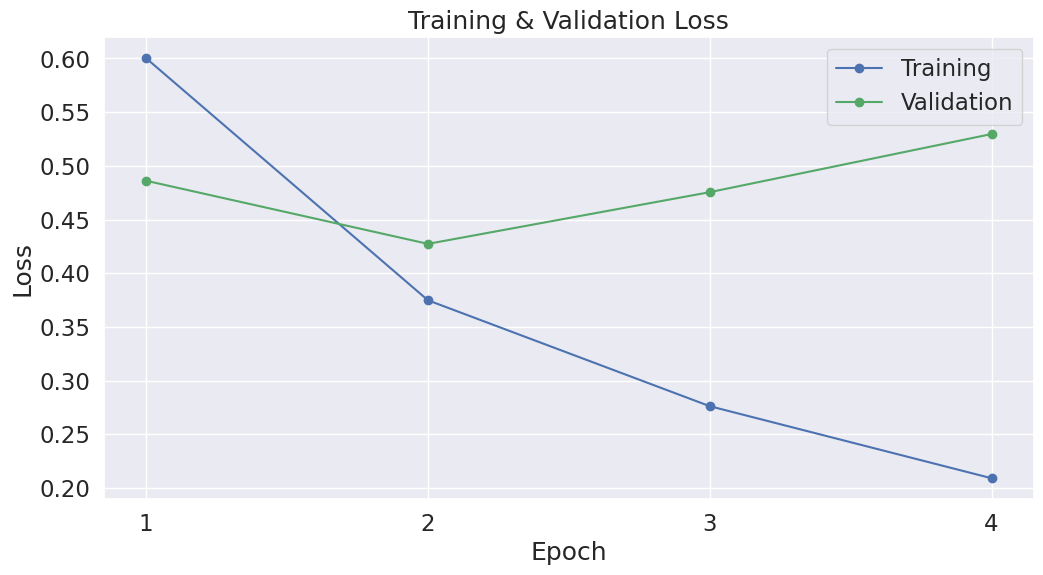

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
model = torch.load('bert_model_bbc')

In [ ]:
# Create sentence and label lists
sentences = test.text.values
labels = test.text_sentiment.values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len=160
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )


    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,790 test sentences...
    DONE.


In [ ]:
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)
accuracy_score(scores, labels)

0.8646539027982327

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

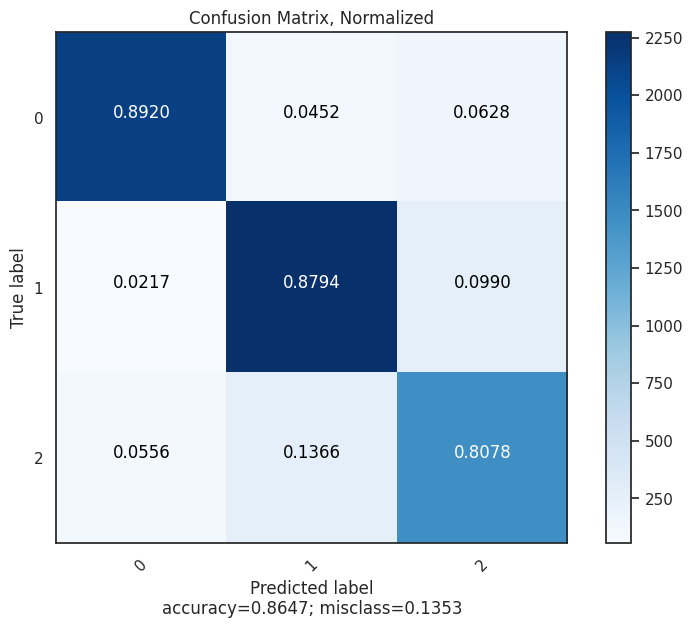

In [ ]:
sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['0', '1', '2'],
                      title        = "Confusion Matrix, Normalized")